In [1]:
# to import .py module
import sys
import os
ROOT_DIR = os.path.abspath(os.curdir)[:-11]
sys.path.append(os.path.abspath(ROOT_DIR))

In [2]:
import codecs
import json
import Preprocess
from Parameters import *
import numpy as np
import keras
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Embedding, Input, Dense, Reshape, Concatenate, Flatten, Bidirectional, LSTM, Activation, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.regularizers import l2
from time import time
import multiprocessing as mp
import sys
import math
import tensorflow as tf
import timeit
import CRF

### Bert model

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import json

def get_model(model_url, max_seq_length):
  labse_layer = hub.KerasLayer(model_url, trainable=True)

  # Define input.
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
  segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")

  # LaBSE layer.
  pooled_output,  _ = labse_layer([input_word_ids, input_mask, segment_ids])

  # The embedding is l2 normalized.
  pooled_output = tf.keras.layers.Lambda(
      lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)

  # Define model.
  return tf.keras.Model(
        inputs=[input_word_ids, input_mask, segment_ids],
        outputs=pooled_output), labse_layer

max_seq_length = 64
labse_model, labse_layer = get_model(
    model_url="https://tfhub.dev/google/LaBSE/1", max_seq_length=max_seq_length)

In [ ]:
import bert

vocab_file = labse_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = labse_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

def create_input(input_strings, tokenizer, max_seq_length):

  input_ids_all, input_mask_all, segment_ids_all = [], [], []
  for input_string in input_strings:
    # Tokenize input.
    input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
    sequence_length = min(len(input_ids), max_seq_length)

    # Padding or truncation.
    if len(input_ids) >= max_seq_length:
      input_ids = input_ids[:max_seq_length]
    else:
      input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

    input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

    input_ids_all.append(input_ids)
    input_mask_all.append(input_mask)
    segment_ids_all.append([0] * max_seq_length)

  return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)

def encode(input_text):
  input_ids, input_mask, segment_ids = create_input(
    input_text, tokenizer, max_seq_length)
  return labse_model([input_ids, input_mask, segment_ids])

### Model

#### Load data and define necessary parameters, functions

In [ ]:
import json
with open(TRAIN_DATA_FILE, encoding='utf8') as f:
  trainset = json.load(f)

In [ ]:
with open(file=NORM_ADDS_FILE, mode='r', encoding='utf-8') as f:
  NORM_ADDS = json.load(fp=f)

with open(file=ID2id_FILE, mode='r', encoding='utf-8') as f:
  ID2id = json.load(fp=f)

with open(file=id2ID_FILE, mode='r', encoding='utf-8') as f:
  id2ID = json.load(fp=f)

with open(file=id2norm_add_FILE, mode='r', encoding='utf-8') as f:
  id2norm_add= json.load(fp=f)

In [ ]:
norm_embeddings = np.load(NORM_EMBEDDING_FILE, allow_pickle=True)
NT_norm_embeddings = np.load(NT_NORM_EMBEDDING_FILE, allow_pickle=True)

In [ ]:
# noisy_add = trainset['data'][119]['noisy_add']

In [ ]:
# entities = CRF.detect_entity(noisy_add)
# entities

In [ ]:
entities2index = {'street': 0, 'ward': 1, 'district': 2, 'city': 3}

In [ ]:
def create_type_add_vector(noisy_add):
  entities = CRF.detect_entity(noisy_add)
  type_add_vector = np.zeros((1,4))
  for entity in entities:
    if entity == 'name':
      pass
    else:
      index = entities2index[entity]
      type_add_vector[0, index] = 1
  return type_add_vector

In [ ]:
# for a sample in trainset, get id of norm_add coresponding to noisy_add of this sample
def get_norm_id(sample):
  return list(sample['std_add'].keys())[0]

In [ ]:
# norm_embeddings.shape
dim = 772
num_of_norm = 34481
num_negative = 1023
SNN_layers = [512, 256, 128]
MLP_layers = [64, 32, 16, 8]

#### Generator

In [ ]:
def concat(v,type_add_vector):
  return np.concatenate((v, type_add_vector), axis=1)

In [ ]:
def generator(trainset, num_negative, id2norm_add, dim):
  # for i, sample in enumerate(trainset['data'][:100]):
  for i, sample in enumerate(trainset['data'][:32932]):
    batch_size = num_negative + 1
    batch_indexes = np.array([i for i in range(batch_size)])
    noisy_adds, norm_adds, labels = [], [], []
    # noisy add có thể hoa hoặc thường, đưa về chữ thường hết và loại bỏ đi punctuation
    noisy_add = preprocess.remove_punctuation(CRF.get_better_add(sample['noisy_add']).lower())

    id = get_norm_id(sample)
    ID_ = int(id2ID[id])

    type_add_vector = create_type_add_vector(sample['noisy_add'])
    noisy_add_vector = concat(np.array(encode([noisy_add])), type_add_vector)

    # kiểm tra xem noisy_add truyền vào là thường hay hoa
    if noisy_add != preprocess.remove_tone_of_text(noisy_add):
      noisy_adds.append(noisy_add_vector)
      norm_adds.append(norm_embeddings[ID_, :].reshape(1, -1))
      labels.append(1)

      # nagative sample
      for t in range(num_negative):
        j = str(np.random.randint(num_of_norm))
        while (j not in id2norm_add) or (j == id):
          j = str(np.random.randint(num_of_norm))

        ID = int(id2ID[j])
        noisy_adds.append(noisy_add_vector)
        norm_adds.append(norm_embeddings[ID, :].reshape(1, -1))
        labels.append(0)

    else:
      noisy_adds.append(noisy_add_vector)
      norm_adds.append(NT_norm_embeddings[ID_, :].reshape(1, -1))
      labels.append(1)

      # negative sample
      for t in range(num_negative):
        j = str(np.random.randint(num_of_norm))
        while (j not in id2norm_add) or (j == id):
          j = str(np.random.randint(num_of_norm))

        ID = int(id2ID[j])
        noisy_adds.append(noisy_add_vector)
        norm_adds.append(NT_norm_embeddings[ID, :].reshape(1, -1))
        labels.append(0)

    np.random.shuffle(batch_indexes)
    yield [np.array(noisy_adds).reshape(batch_size, dim)[batch_indexes], np.array(norm_adds).reshape(batch_size, dim)[batch_indexes]], np.array(labels)[batch_indexes]

#### Model

In [ ]:
class CustomLayer(keras.layers.Layer):
    def __init__(self, input_dim):
        super(CustomLayer, self).__init__()
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value=w_init(shape=(input_dim,), dtype="float32"),
            trainable=True,
        )
    def call(self, input_):
        return tf.multiply(input_, self.w)

def get_SNN_model(dim,
                  SNN_layers,
                  MLP_layers, 
                  type_ = None):
    num_SNN_layers = len(SNN_layers)

    noisy_input         = Input(shape=(dim,), dtype=np.float32, name='noisy_input')
    norm_input          = Input(shape=(dim,), dtype=np.float32, name='norm_input')

    if type_ == 'add':
      noisy_latent = noisy_input
      norm_latent = norm_input
      # SNN layer
      for idx in range(num_SNN_layers):
        Dense_layer = Dense(units=SNN_layers[idx]) 
        noisy_latent = Dense_layer(noisy_latent)
        norm_latent = Dense_layer(norm_latent)

        Activation_layer = keras.layers.LeakyReLU(alpha=0.1)
        noisy_latent = Activation_layer(noisy_latent)
        norm_latent = Activation_layer(norm_latent)
        # noisy_latent = keras.layers.BatchNormalization()(noisy_latent)
        # norm_latent = keras.layers.BatchNormalization()(norm_latent)
        # noisy_latent = Dropout(0.2)(noisy_latent)
        # norm_latent = Dropout(0.2)(norm_latent)

      noisy_latent = CustomLayer(input_dim=SNN_layers[-1])(noisy_latent)
      norm_latent = CustomLayer(input_dim=SNN_layers[-1])(norm_latent)
      predict_vector = tf.keras.layers.Add()([noisy_latent, norm_latent])

      # MLP layers
      for idx in range(len(MLP_layers)):
        Dense_layer = Dense(units=MLP_layers[idx]) 
        predict_vector = Dense_layer(predict_vector)

        Activation_layer = keras.layers.LeakyReLU(alpha=0.1)
        predict_vector = Activation_layer(predict_vector)
        # predict_vector = keras.layers.BatchNormalization()(predict_vector)   
        # predict_vector = Dropout(0.2)(predict_vector)

      # Add a dense layer with a sigmoid unit to generate the similarity score
      prediction = Dense(1,activation='sigmoid')(predict_vector)
      
      # Connect the inputs with the outputs
      siamese_net = keras.models.Model(inputs=[noisy_input,norm_input],outputs=prediction)
      
      # return the model
      return siamese_net
    elif type_ == 'cosine':
      noisy_latent = noisy_input
      norm_latent = norm_input
      # SNN layer
      for idx in range(num_SNN_layers):
        Dense_layer = Dense(units=SNN_layers[idx]) 
        noisy_latent = Dense_layer(noisy_latent)
        norm_latent = Dense_layer(norm_latent)

        Activation_layer = keras.layers.LeakyReLU(alpha=0.1)
        noisy_latent = Activation_layer(noisy_latent)
        norm_latent = Activation_layer(norm_latent)

      L1_layer = keras.layers.Lambda(lambda tensors:-keras.losses.cosine_similarity(tensors[0],tensors[1], axis=-1))
      prediction = L1_layer([noisy_latent, norm_latent])
      siamese_net = keras.models.Model(inputs=[noisy_input,norm_input],outputs=prediction)
      return siamese_net
keras.backend.clear_session()

#### Train all data

In [ ]:
# SNN_embedding_model = SNN_embedding(dim, SNN_layers)
# SNN_embedding_model.summary()

In [ ]:
SNN_model = get_SNN_model(dim, SNN_layers, MLP_layers, type_='cosine')
SNN_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noisy_input (InputLayer)        [(None, 772)]        0                                            
__________________________________________________________________________________________________
norm_input (InputLayer)         [(None, 772)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          395776      noisy_input[0][0]                
                                                                 norm_input[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                

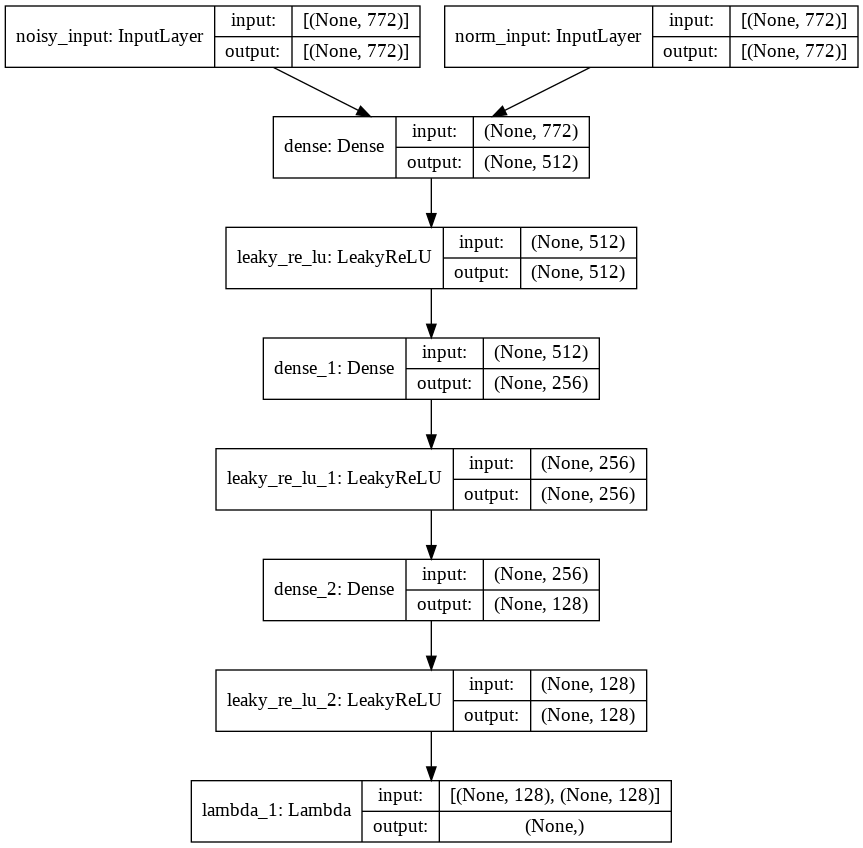

In [ ]:
tf.keras.utils.plot_model(SNN_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
SNN_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.binary_crossentropy)

### train

In [ ]:
losses = []
start = timeit.default_timer()
for i in range(20):
  train_data_gen = generator(trainset, num_negative, id2norm_add, dim)
  hist = SNN_model.fit(train_data_gen, verbose=1)
  losses.append(hist.history['loss'][0])
  SNN_model.save(filepath='_'.join(['/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN', str(i+1), 'epoches.snn']))
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(losses)

In [ ]:
losses = []
SNN_model = keras.models.load_model('/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_20_epoches.snn')
start = timeit.default_timer()
for i in range(20, 40):
  train_data_gen = generator(trainset, num_negative, id2norm_add, dim)
  hist = SNN_model.fit(train_data_gen, verbose=1)
  losses.append(hist.history['loss'][0])
  SNN_model.save(filepath='_'.join(['/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN', str(i+1), 'epoches.snn']))
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(losses)

32932/32932 [==============================] - 1320s 40ms/step - loss: 4.3514e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_21_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_21_epoches.snn/assets


32932/32932 [==============================] - 1350s 41ms/step - loss: 4.0538e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_22_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_22_epoches.snn/assets


32932/32932 [==============================] - 1434s 44ms/step - loss: 3.8424e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_23_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_23_epoches.snn/assets


32932/32932 [==============================] - 1336s 41ms/step - loss: 3.6191e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_24_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_24_epoches.snn/assets


32932/32932 [==============================] - 1305s 40ms/step - loss: 3.4388e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_25_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_25_epoches.snn/assets


32932/32932 [==============================] - 1248s 38ms/step - loss: 3.2434e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_26_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_26_epoches.snn/assets


32932/32932 [==============================] - 1244s 38ms/step - loss: 3.0586e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_27_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_27_epoches.snn/assets


32932/32932 [==============================] - 1241s 38ms/step - loss: 2.9262e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_28_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_28_epoches.snn/assets


32932/32932 [==============================] - 1226s 37ms/step - loss: 2.7878e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_29_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_29_epoches.snn/assets


32932/32932 [==============================] - 1249s 38ms/step - loss: 2.6575e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_30_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_30_epoches.snn/assets


32932/32932 [==============================] - 1238s 38ms/step - loss: 2.6123e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_31_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_31_epoches.snn/assets


32932/32932 [==============================] - 1328s 40ms/step - loss: 2.4699e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_32_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_32_epoches.snn/assets


32932/32932 [==============================] - 1282s 39ms/step - loss: 2.3279e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_33_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_33_epoches.snn/assets


32932/32932 [==============================] - 1271s 39ms/step - loss: 2.2944e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_34_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_34_epoches.snn/assets


32932/32932 [==============================] - 1280s 39ms/step - loss: 2.2157e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_35_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_35_epoches.snn/assets


32932/32932 [==============================] - 1252s 38ms/step - loss: 2.1182e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_36_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_36_epoches.snn/assets


32932/32932 [==============================] - 1349s 41ms/step - loss: 2.0422e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_37_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_37_epoches.snn/assets


32932/32932 [==============================] - 1281s 39ms/step - loss: 1.9812e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_38_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_38_epoches.snn/assets


  27329/Unknown - 1042s 38ms/step - loss: 1.9306e-04

In [ ]:
losses = []
SNN_model = keras.models.load_model('/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_38_epoches.snn')
start = timeit.default_timer()
for i in range(38, 60):
  train_data_gen = generator(trainset, num_negative, id2norm_add, dim)
  hist = SNN_model.fit(train_data_gen, verbose=1)
  losses.append(hist.history['loss'][0])
  SNN_model.save(filepath='_'.join(['/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN', str(i+1), 'epoches.snn']))
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(losses)

32932/32932 [==============================] - 1269s 39ms/step - loss: 1.9371e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_39_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_39_epoches.snn/assets


32932/32932 [==============================] - 1257s 38ms/step - loss: 1.8603e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_40_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_40_epoches.snn/assets


32932/32932 [==============================] - 1243s 38ms/step - loss: 1.7878e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_41_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_41_epoches.snn/assets


32932/32932 [==============================] - 1282s 39ms/step - loss: 1.7405e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_42_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_42_epoches.snn/assets


32932/32932 [==============================] - 1246s 38ms/step - loss: 1.7192e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_43_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_43_epoches.snn/assets


32932/32932 [==============================] - 1217s 37ms/step - loss: 1.6695e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_44_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_44_epoches.snn/assets


32932/32932 [==============================] - 1267s 38ms/step - loss: 1.6162e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_45_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_45_epoches.snn/assets


32932/32932 [==============================] - 1228s 37ms/step - loss: 1.6165e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_46_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_46_epoches.snn/assets


32932/32932 [==============================] - 1212s 37ms/step - loss: 1.5954e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_47_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_47_epoches.snn/assets


32932/32932 [==============================] - 1241s 38ms/step - loss: 1.5098e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_48_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_48_epoches.snn/assets


32932/32932 [==============================] - 1217s 37ms/step - loss: 1.4505e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_49_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_49_epoches.snn/assets


32932/32932 [==============================] - 1229s 37ms/step - loss: 1.4270e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_50_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_50_epoches.snn/assets


32932/32932 [==============================] - 1217s 37ms/step - loss: 1.4479e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_51_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_51_epoches.snn/assets


32932/32932 [==============================] - 1241s 38ms/step - loss: 1.3935e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_52_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_52_epoches.snn/assets


32932/32932 [==============================] - 1230s 37ms/step - loss: 1.3462e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_53_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_53_epoches.snn/assets


32932/32932 [==============================] - 1198s 36ms/step - loss: 1.3175e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_54_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_54_epoches.snn/assets


32932/32932 [==============================] - 1196s 36ms/step - loss: 1.3012e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_55_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_55_epoches.snn/assets


32932/32932 [==============================] - 1200s 36ms/step - loss: 1.2579e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_56_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_56_epoches.snn/assets


32932/32932 [==============================] - 1203s 37ms/step - loss: 1.3004e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_57_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_57_epoches.snn/assets


32932/32932 [==============================] - 1206s 37ms/step - loss: 1.2304e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_58_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_58_epoches.snn/assets


32932/32932 [==============================] - 1234s 37ms/step - loss: 1.2043e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_59_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_59_epoches.snn/assets


32932/32932 [==============================] - 1257s 38ms/step - loss: 1.2000e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_60_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_60_epoches.snn/assets


Time:  27125.744984590998
[0.000193709900486283, 0.00018602641648612916, 0.00017878011567518115, 0.00017404921527486295, 0.00017191586084663868, 0.00016694888472557068, 0.0001616221125004813, 0.0001616520603420213, 0.0001595361391082406, 0.0001509840221842751, 0.0001450510899303481, 0.00014270104293245822, 0.00014479378296528012, 0.00013935343304183334, 0.00013462368224281818, 0.0001317469432251528, 0.0001301185693591833, 0.0001257908734260127, 0.0001300372532568872, 0.00012303506082389504, 0.00012042836897308007, 0.00011999677371932194]


In [ ]:
losses = []
SNN_model = keras.models.load_model('/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_60_epoches.snn')
start = timeit.default_timer()
for i in range(60, 80):
  train_data_gen = generator(trainset, num_negative, id2norm_add, dim)
  hist = SNN_model.fit(train_data_gen, verbose=1)
  losses.append(hist.history['loss'][0])
  SNN_model.save(filepath='_'.join(['/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN', str(i+1), 'epoches.snn']))
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(losses)

32932/32932 [==============================] - 1286s 39ms/step - loss: 1.1515e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_61_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_61_epoches.snn/assets


32932/32932 [==============================] - 1289s 39ms/step - loss: 1.1487e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_62_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_62_epoches.snn/assets


32932/32932 [==============================] - 1289s 39ms/step - loss: 1.1278e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_63_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_63_epoches.snn/assets


32932/32932 [==============================] - 1250s 38ms/step - loss: 1.1475e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_64_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_64_epoches.snn/assets


    335/Unknown - 13s 39ms/step - loss: 9.7935e-05Buffered data was truncated after reaching the output size limit.

In [ ]:
losses = []
SNN_model = keras.models.load_model('/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_68_epoches.snn')
start = timeit.default_timer()
for i in range(68, 80):
  train_data_gen = generator(trainset, num_negative, id2norm_add, dim)
  hist = SNN_model.fit(train_data_gen, verbose=1)
  losses.append(hist.history['loss'][0])
  SNN_model.save(filepath='_'.join(['/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN', str(i+1), 'epoches.snn']))
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(losses)

32932/32932 [==============================] - 1327s 40ms/step - loss: 1.0695e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_69_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_69_epoches.snn/assets


32932/32932 [==============================] - 1296s 39ms/step - loss: 1.0554e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_70_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_70_epoches.snn/assets


32932/32932 [==============================] - 1311s 40ms/step - loss: 9.9675e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_71_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_71_epoches.snn/assets


  32822/Unknown - 1318s 40ms/step - loss: 1.0297e-04Buffered data was truncated after reaching the output size limit.

In [ ]:
losses = []
SNN_model = keras.models.load_model('/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_72_epoches.snn')
start = timeit.default_timer()
for i in range(72, 80):
  train_data_gen = generator(trainset, num_negative, id2norm_add, dim)
  hist = SNN_model.fit(train_data_gen, verbose=1)
  losses.append(hist.history['loss'][0])
  SNN_model.save(filepath='_'.join(['/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN', str(i+1), 'epoches.snn']))
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(losses)

32932/32932 [==============================] - 1203s 37ms/step - loss: 1.0017e-04
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_73_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_73_epoches.snn/assets


32932/32932 [==============================] - 1202s 37ms/step - loss: 9.5956e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_74_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_74_epoches.snn/assets


32932/32932 [==============================] - 1225s 37ms/step - loss: 9.3930e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_75_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_75_epoches.snn/assets


32932/32932 [==============================] - 1218s 37ms/step - loss: 9.1915e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_76_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_76_epoches.snn/assets


    800/Unknown - 30s 38ms/step - loss: 1.0718e-04Buffered data was truncated after reaching the output size limit.

In [ ]:
losses = []
SNN_model = keras.models.load_model('/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_80_epoches.snn')
start = timeit.default_timer()
for i in range(80, 100):
  train_data_gen = generator(trainset, num_negative, id2norm_add, dim)
  hist = SNN_model.fit(train_data_gen, verbose=1)
  losses.append(hist.history['loss'][0])
  SNN_model.save(filepath='_'.join(['/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN', str(i+1), 'epoches.snn']))
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(losses)

32932/32932 [==============================] - 1262s 38ms/step - loss: 8.8113e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_81_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_81_epoches.snn/assets


32932/32932 [==============================] - 1289s 39ms/step - loss: 8.7949e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_82_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_82_epoches.snn/assets


32932/32932 [==============================] - 1264s 38ms/step - loss: 8.9349e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_83_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_83_epoches.snn/assets


32932/32932 [==============================] - 1258s 38ms/step - loss: 8.7932e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_84_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_84_epoches.snn/assets


32932/32932 [==============================] - 1285s 39ms/step - loss: 8.3024e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_85_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_85_epoches.snn/assets


32932/32932 [==============================] - 1270s 39ms/step - loss: 8.3212e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_86_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_86_epoches.snn/assets


32932/32932 [==============================] - 1258s 38ms/step - loss: 8.1926e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_87_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_87_epoches.snn/assets


32932/32932 [==============================] - 1259s 38ms/step - loss: 8.0610e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_88_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_88_epoches.snn/assets


32932/32932 [==============================] - 1235s 37ms/step - loss: 8.0385e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_89_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_89_epoches.snn/assets


32932/32932 [==============================] - 1252s 38ms/step - loss: 7.9869e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_90_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_90_epoches.snn/assets


32932/32932 [==============================] - 1238s 38ms/step - loss: 7.9916e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_91_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_91_epoches.snn/assets


32932/32932 [==============================] - 1253s 38ms/step - loss: 7.7752e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_92_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_92_epoches.snn/assets


32932/32932 [==============================] - 1257s 38ms/step - loss: 7.9782e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_93_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_93_epoches.snn/assets


32932/32932 [==============================] - 1263s 38ms/step - loss: 7.8399e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_94_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_94_epoches.snn/assets


32932/32932 [==============================] - 1361s 41ms/step - loss: 8.1605e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_95_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_95_epoches.snn/assets


32932/32932 [==============================] - 1257s 38ms/step - loss: 7.5284e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_96_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_96_epoches.snn/assets


32932/32932 [==============================] - 1263s 38ms/step - loss: 7.5182e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_97_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_97_epoches.snn/assets


32932/32932 [==============================] - 1250s 38ms/step - loss: 7.1862e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_98_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_98_epoches.snn/assets


32932/32932 [==============================] - 1245s 38ms/step - loss: 7.5806e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_99_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_99_epoches.snn/assets


32932/32932 [==============================] - 1230s 37ms/step - loss: 7.3973e-05
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_100_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Add_model_1.4.4.2/SNN_100_epoches.snn/assets


Time:  25281.114751169
[8.811291627353057e-05, 8.794858877081424e-05, 8.934931247495115e-05, 8.793195593170822e-05, 8.302435890072957e-05, 8.32117220852524e-05, 8.192573295673355e-05, 8.060975960688666e-05, 8.038525993470103e-05, 7.986852142494172e-05, 7.99161207396537e-05, 7.775204721838236e-05, 7.978201028890908e-05, 7.839894533390179e-05, 8.160463767126203e-05, 7.528364949394017e-05, 7.518187339883298e-05, 7.186151924543083e-05, 7.580607780255377e-05, 7.39726165193133e-05]


### Train Cosine

In [ ]:
losses = []
start = timeit.default_timer()
for i in range(20):
  train_data_gen = generator(trainset, num_negative, id2norm_add, dim)
  hist = SNN_model.fit(train_data_gen, verbose=1)
  losses.append(hist.history['loss'][0])
  SNN_model.save(filepath='_'.join(['/content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN', str(i+1), 'epoches.snn']))
stop = timeit.default_timer()
print('Time: ', stop - start) 
print(losses)

32932/32932 [==============================] - 1297s 39ms/step - loss: 0.0373
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_1_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_1_epoches.snn/assets


32932/32932 [==============================] - 1293s 39ms/step - loss: 0.0149
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_2_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_2_epoches.snn/assets


32932/32932 [==============================] - 1287s 39ms/step - loss: 0.0125
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_3_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_3_epoches.snn/assets


32932/32932 [==============================] - 1254s 38ms/step - loss: 0.0111
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_4_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_4_epoches.snn/assets


32932/32932 [==============================] - 1269s 39ms/step - loss: 0.0101
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_5_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_5_epoches.snn/assets


32932/32932 [==============================] - 1251s 38ms/step - loss: 0.0094
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_6_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_6_epoches.snn/assets


32932/32932 [==============================] - 1258s 38ms/step - loss: 0.0088
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_7_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_7_epoches.snn/assets


32932/32932 [==============================] - 1283s 39ms/step - loss: 0.0085
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_8_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_8_epoches.snn/assets


32932/32932 [==============================] - 1177s 36ms/step - loss: 0.0081
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_9_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_9_epoches.snn/assets


32932/32932 [==============================] - 1160s 35ms/step - loss: 0.0078
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_10_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_10_epoches.snn/assets


32932/32932 [==============================] - 1179s 36ms/step - loss: 0.0076
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_11_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_11_epoches.snn/assets


32932/32932 [==============================] - 1186s 36ms/step - loss: 0.0074
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_12_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_12_epoches.snn/assets


32932/32932 [==============================] - 1197s 36ms/step - loss: 0.0074
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_13_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_13_epoches.snn/assets


32932/32932 [==============================] - 1170s 36ms/step - loss: 0.0071
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_14_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_14_epoches.snn/assets


32932/32932 [==============================] - 1173s 36ms/step - loss: 0.0070
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_15_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_15_epoches.snn/assets


32932/32932 [==============================] - 1218s 37ms/step - loss: 0.0068
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_16_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_16_epoches.snn/assets


32932/32932 [==============================] - 1223s 37ms/step - loss: 0.0066
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_17_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_17_epoches.snn/assets


32932/32932 [==============================] - 1241s 38ms/step - loss: 0.0064
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_18_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_18_epoches.snn/assets


32932/32932 [==============================] - 1247s 38ms/step - loss: 0.0064
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_19_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_19_epoches.snn/assets


32932/32932 [==============================] - 1221s 37ms/step - loss: 0.0063
INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_20_epoches.snn/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Norm_add_based_recommendation/Full/model_1.2/Cosine_model_1.4.4.2/SNN_20_epoches.snn/assets


Time:  24599.488757659
[0.024486105889081955, 0.014937026426196098, 0.01245044730603695, 0.011058277450501919, 0.010084070265293121, 0.00939374603331089, 0.008840606547892094, 0.008458749391138554, 0.008067813701927662, 0.007809730246663094, 0.007627024780958891, 0.007439479697495699, 0.007421344518661499, 0.007130536716431379, 0.006980838254094124, 0.006809983868151903, 0.006638312246650457, 0.006449973676353693, 0.00643547996878624, 0.006330437492579222]
